# 4 - Feature Importance, Tree Interpreter

[Course Notebook on Github](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb)
### Notes
My goal is not to copy what it is taught in the course and in the notebook. Its just various notes and trying things for my own.

In [1]:
# import
%load_ext autoreload
%autoreload 2


%matplotlib inline
# libs
import os
import pandas as pd
import numpy as np
import re, time
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

from fastai.imports import *
from fastai.structured import *
import feather

In [2]:
set_plot_sizes(12, 14, 16)

## RF Interpration


In [3]:
PATH = './datasets/bluebook_bulldozers/'
df_raw = feather.read_dataframe('tmp/bulldozers-raw')

df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [4]:
def split_vals(a, n): return a[:n], a[n:]
n_valid = 1200
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [5]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [6]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


In [7]:
set_rf_samples(50000)

In [8]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 49.5 s, sys: 1.14 s, total: 50.6 s
Wall time: 7.66 s
[0.20602895184035983, 0.24619115821014484, 0.91171030926919, 0.8725731252349054, 0.8952373452087865]


In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=8, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 29 s, sys: 976 ms, total: 30 s
Wall time: 7.92 s
[0.20665355540629085, 0.24626932328285545, 0.9111741744552, 0.8724921969660452, 0.8946122435022534]


In [10]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.165962
37,Coupler_System,0.140392
13,ProductSize,0.102598
14,fiProductClassDesc,0.075917
10,fiSecondaryDesc,0.055596
63,saleElapsed,0.049233
2,ModelID,0.049089
38,Grouser_Tracks,0.044863
19,Enclosure,0.040380
8,fiModelDesc,0.033276


In [11]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

collinearity - variables related to each other - understimated importance

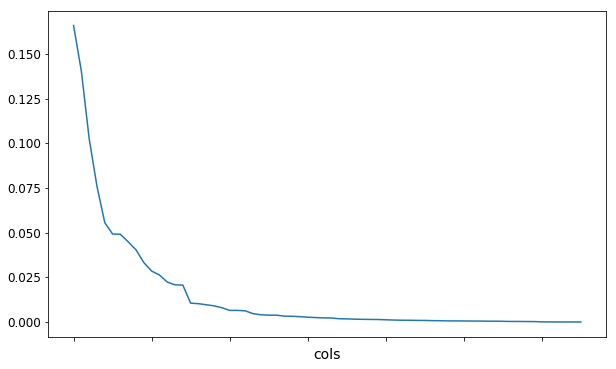

In [12]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [13]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [14]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20811817906747532, 0.24781067520030026, 0.9099106353481058, 0.8708911089425934, 0.894048269254136]


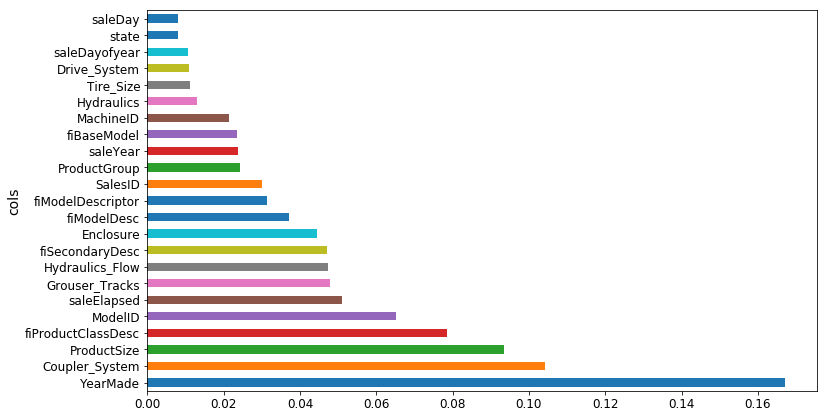

In [15]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

#### One-Hot-Encoding

In [16]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20839064350120487, 0.2520535845798527, 0.9096745943110938, 0.8664321654265605, 0.8923550884174286]


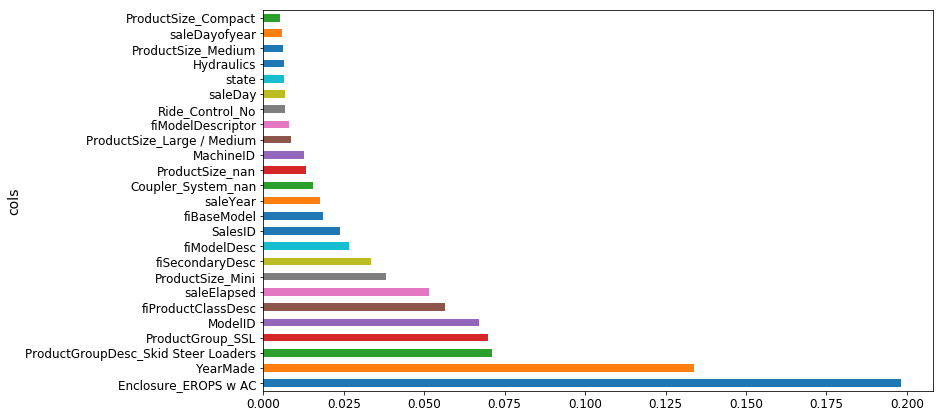

In [17]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

zip - cardinality of 5000 (how many levels)
usabeband - 6 (encode it)
sex - 2 (encode it wiht o-h)

### Removing features

In [18]:
from scipy.cluster import hierarchy as hc

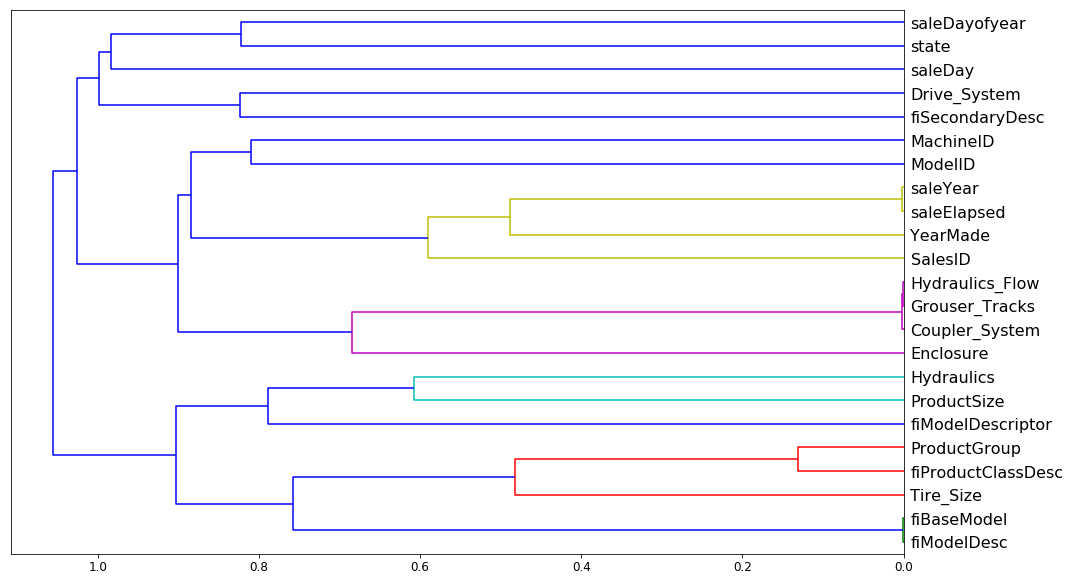

In [19]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Rank Correlation - plot the rank instead of the samples.  
Spearman's R - most famous rank correlation.

In [20]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=8, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [21]:
get_oob(df_keep)

0.8906908674997426

In [22]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8900967816708388
saleElapsed 0.88767234553963
fiModelDesc 0.8894515264367754
fiBaseModel 0.8897651470012972
Grouser_Tracks 0.8902077298281412
Coupler_System 0.8901166033436727


In [23]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8896746202274349

In [24]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [25]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [26]:
reset_rf_samples()

In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12469739243868651, 0.22335823777078595, 0.9676578986789016, 0.8951133830133982, 0.9095679721741547]


### Partial Dependance

In [28]:
from plotnine import *
from pdpbox import pdp

In [29]:
set_rf_samples(50000)

In [30]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

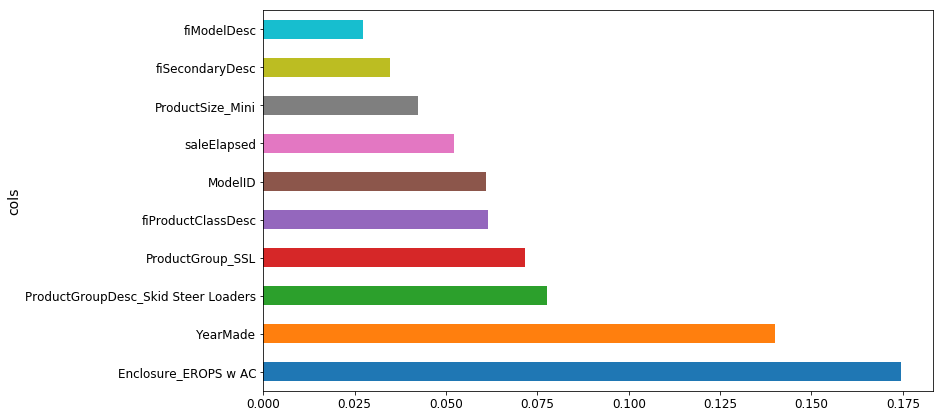

In [31]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

For the important features how they related to the dependant variable.

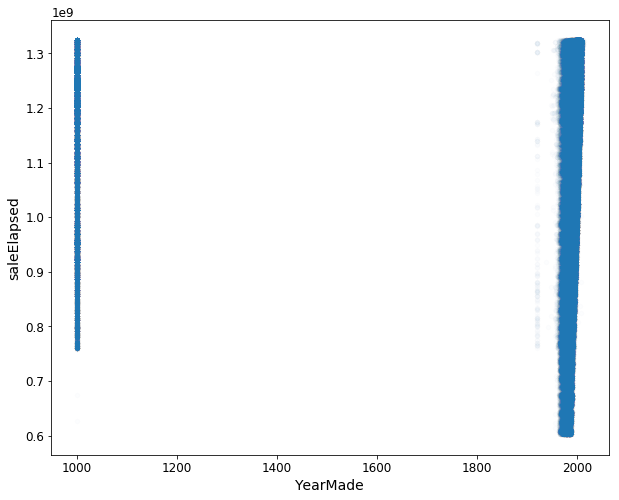

In [32]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [33]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

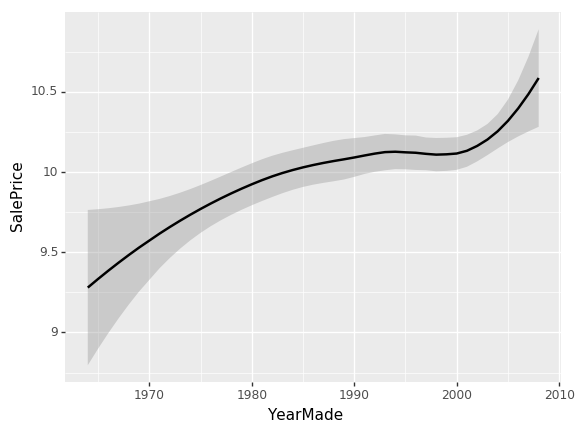

<ggplot: (8743610850543)>

In [36]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')
# se - standard error - adds confidence interval

Plotting things - reduce samples.

In [37]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [44]:
def plot_pdp(feat_name, clusters=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3c7cd406d8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3c7ce47d68>})

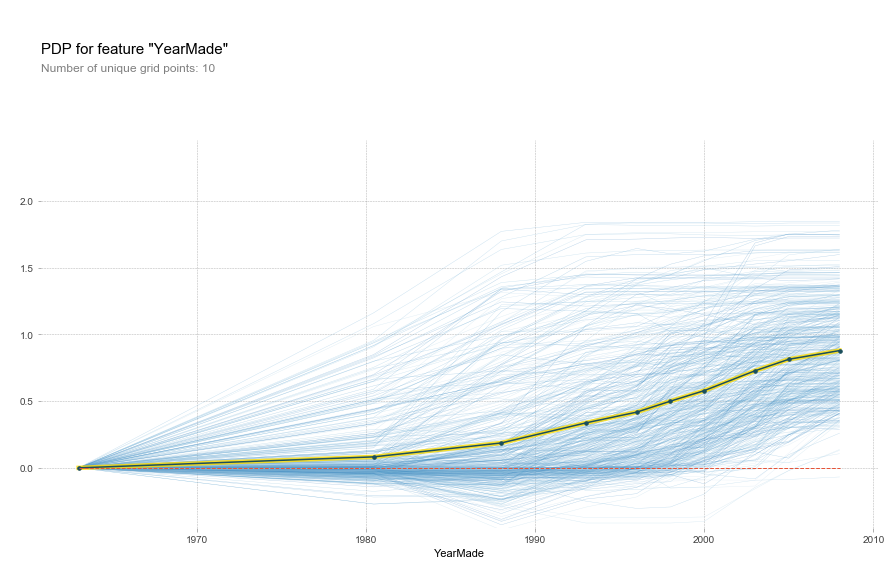

In [45]:
plot_pdp(feat_name='YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3c7b78c7b8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3c7b772e48>})

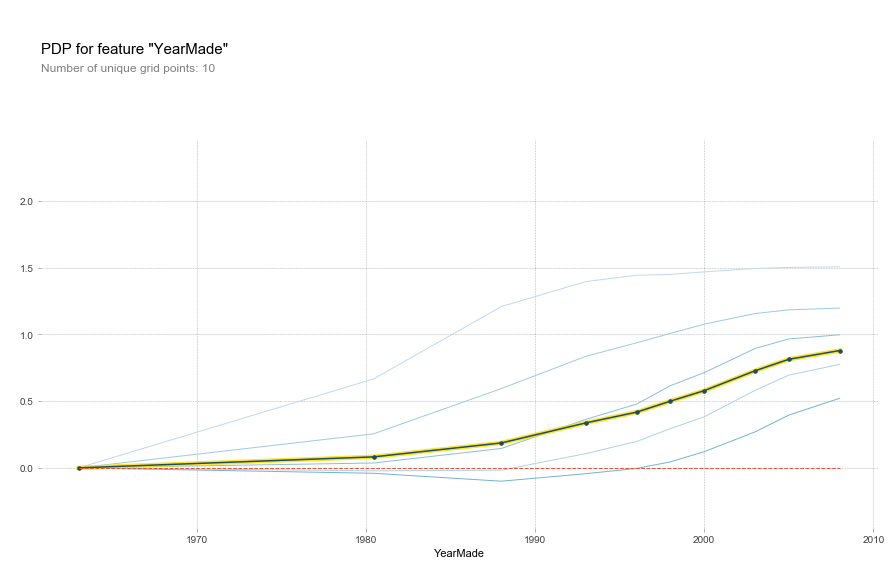

In [46]:
plot_pdp('YearMade', clusters=5)


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3c61d9ce80>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3c61c91cc0>})

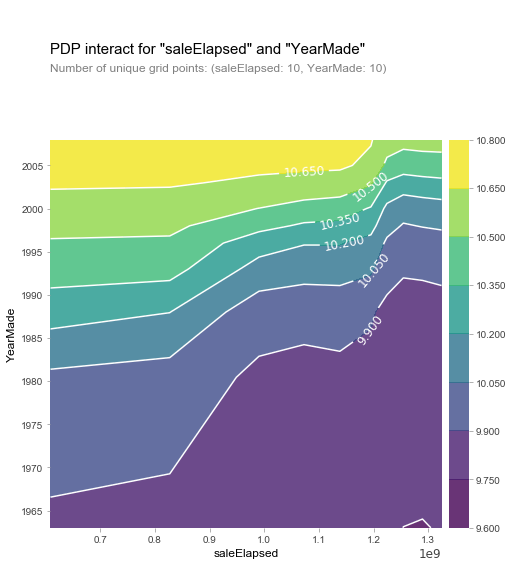

In [51]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, features=feats, model_features=x.columns)
pdp.pdp_interact_plot(p, feats)
## pdp plot updated - refer to the original notebook

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3c61cebb70>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3c61d1d208>})

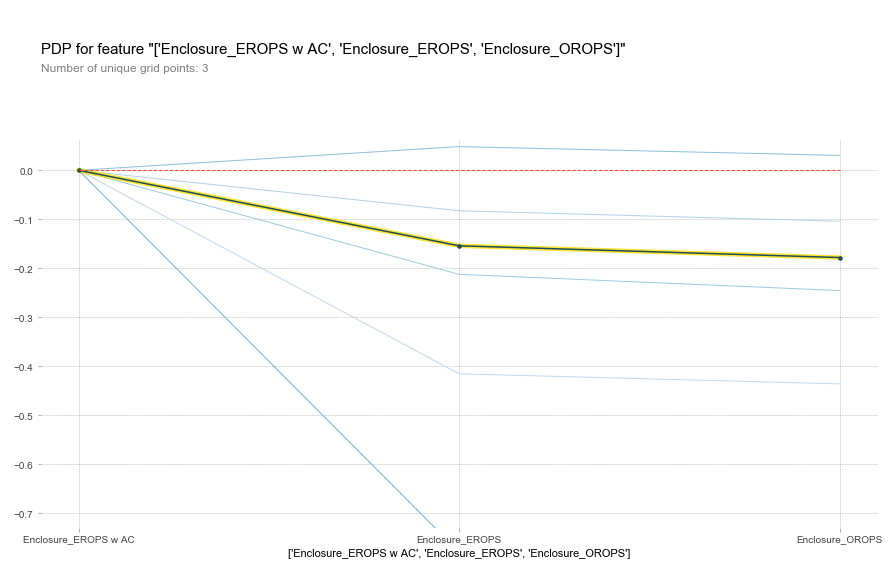

In [52]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], clusters=5)

In [53]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

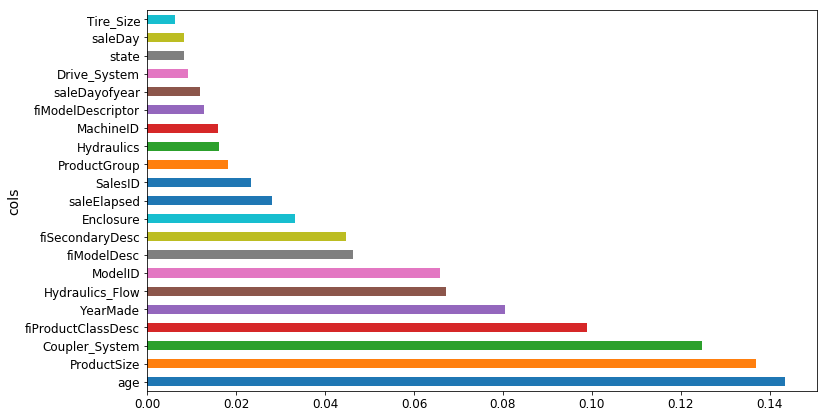

In [54]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

### Tree interpreter

In [56]:
from treeinterpreter import treeinterpreter as ti

In [57]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [58]:
row = X_valid.values[None,0]; row

array([[      2005,          1,          0,         43,          0, 1324339200,      17318,          6,
              4464,          0,    6311459,    1835718,          3,          3,          4,          0,
                 0,         20,         43,        354,          6]])

In [59]:
prediction, bias, contributions = ti.predict(m, row)

In [60]:
prediction[0], bias[0] # bias - the avg. sale price

(array([9.52332]), 10.10463284531329)

In [61]:
idxs = np.argsort(contributions[0])

In [62]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('Coupler_System', 'None or Unspecified', -0.543688182980366),
 ('Hydraulics_Flow', 'Standard', -0.3035164342430591),
 ('age', 6, -0.060676402477307254),
 ('ProductSize', nan, -0.035201318101933096),
 ('Enclosure', 'OROPS', -0.02453172499976324),
 ('saleDayofyear', 354, -0.02135447452617343),
 ('SalesID', 6311459, -0.013376535003091083),
 ('fiSecondaryDesc', nan, -0.008149610086770709),
 ('ProductGroup', 'SSL', -0.007923193739910194),
 ('Hydraulics', 'Auxiliary', -0.0040603327312968675),
 ('fiModelDescriptor', nan, -0.0027918986556702665),
 ('Tire_Size', nan, 0.0),
 ('Drive_System', nan, 0.0),
 ('state', 'Tennessee', 0.003696124414777291),
 ('saleDay', 20, 0.0038063250181405105),
 ('MachineID', 1835718, 0.004964217574674956),
 ('ModelID', 17318, 0.008943917485822128),
 ('fiModelDesc', 'T250', 0.016178782416288628),
 ('saleElapsed', 1324339200, 0.050563122728412416),
 ('YearMade', 2005, 0.16813673375176888),
 ('fiProductClassDesc',
  'Skid Steer Loader - 2701.0+ Lb Operating Capacity',

In [63]:
contributions[0].sum()

-0.5813157759390764